In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
torch.__version__

'2.0.1+cu118'

In [4]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Task 1: Image Classification with CNNs

In [5]:
class MyArchitecture(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=50000, out_features=out_features)
        )
    def forward(self,x):
        x = self.conv_layer(x)
        return self.classifier(x)

In [14]:
def preprocessing(img):
    img = cv2.resize(img, (100, 100))

    # Convert to tensor and normalize
    img = transforms.ToTensor()(img)

    return img

# Loading the Data

In [16]:
import os, cv2
import numpy as np
from torchvision import transforms
from PIL import Image

# Define breed-to-category mapping
breed_to_category = {
    "abyssinian": 0,
    "american shorthair": 1,       
    "beagle": 2,
    "boxer": 3,
    "bulldog":4,
    "chihuahua":5,
    "corgi":6,
    "dachshund":7,
    "german shepherd":8,
    "golden retriever":9,
    "husky":10,
    "labrador":11,
    "maine coon":12,
    "mumbai cat":13,
    "persian cat":14,
    "pomeranian":15,
    "pug":16,
    "ragdoll cat":17,
    "rottwiler":18,
    "shiba inu":19,
    "siamese cat":20,
    "sphynx":21,
    "yorkshire terrier":22
}

data_dir = "E:/Data/Pet_Breeds"

labels=[]
data = []
for root, _, files in os.walk(data_dir):
    # print(len(files))
    for image_file in files:
        breed_name = os.path.basename(root)
        label = breed_to_category[breed_name]
        image_path = os.path.join(root, image_file)
        # print(image_path)
        image_matrix = preprocessing(cv2.imread(image_path))
        data.append(image_matrix)
        labels.append(label)

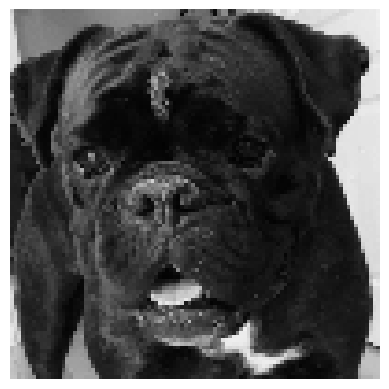

In [22]:

# Display the preprocessed image
plt.imshow(data[np.random.randint(1,1222)].numpy().transpose(1,2,0))
plt.axis("off")
plt.show()

# Creating Datasets for Training and Testing

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [25]:
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


# Create dataset and data loaders
train_dataset = CustomDataset(data=X_train, labels=y_train, transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = CustomDataset(data=X_test, labels=y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Creating a function for training loop

In [27]:
def train_model_loop(model, epochs, loss, optimizer, a, device, train_loader, test_loader):
    '''model refers to the architecture class.
    loss refers to the loss function
    'a' refers to the accuracy function'''
    model.to(device)
    from tqdm import tqdm
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        for X_train,y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            model.train()
            y_pred = model(X_train.float())
            cost = loss(y_pred, y_train)
            train_loss += cost.item()
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            model.eval()    
        with torch.inference_mode():
            test_loss = 0
            te_a=0
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                y_pred_test = model(X_test.float())
                te_a += a(y_pred_test.argmax(dim=1),y_test)
                test_loss += loss(y_pred_test, y_test)
            y_pred_test = model(X_test.float())
            # te_a = a(y_pred_test.argmax(dim=1),y_test)
            # print('preds:',y_pred_test.shape,y_pred_test)
            # tr_a = a(y_pred.argmax(dim=1),y_train)
            if epoch%10==0:
                print(f"Train Loss: {train_loss/len(train_loader)} | Test Accuracy: {te_a/len(test_loader)} | Test Loss: {test_loss/len(test_loader)}")

# Testing 'MyArchitecture'

In [28]:
device = 'cuda'
from timeit import default_timer as timer
import torchmetrics
def print_train_time(start,end,device):
    total_time = end - start
    print(f"Total time on {device} = {total_time:.3f} seconds")
model = MyArchitecture(3, 23, 20)
a = torchmetrics.Accuracy(task='multiclass',num_classes=23).to(device)
model.to(device)
epochs = 80
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
start = timer()
train_model_loop(model,epochs,loss,optimizer,a,device,train_loader, test_loader)
end = timer()
print_train_time(start,end,device)        

C:\Users\Ubaid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|▏         | 1/80 [00:07<09:40,  7.35s/it]

Train Loss: 3.1332653201356226 | Test Accuracy: 0.05301816388964653 | Test Loss: 3.1229238510131836


 14%|█▍        | 11/80 [00:17<01:15,  1.10s/it]

Train Loss: 2.968660894705325 | Test Accuracy: 0.07331731170415878 | Test Loss: 3.04819393157959


 26%|██▋       | 21/80 [00:28<01:01,  1.04s/it]

Train Loss: 2.8189540152647057 | Test Accuracy: 0.10002671182155609 | Test Loss: 3.0160202980041504


 39%|███▉      | 31/80 [00:38<00:51,  1.05s/it]

Train Loss: 2.6942915673158607 | Test Accuracy: 0.11057692766189575 | Test Loss: 3.0315587520599365


 51%|█████▏    | 41/80 [00:49<00:40,  1.05s/it]

Train Loss: 2.5727428952041937 | Test Accuracy: 0.12526710331439972 | Test Loss: 2.9670708179473877


 64%|██████▍   | 51/80 [00:59<00:30,  1.04s/it]

Train Loss: 2.4365925059026603 | Test Accuracy: 0.12753739953041077 | Test Loss: 3.0394749641418457


 76%|███████▋  | 61/80 [01:10<00:20,  1.07s/it]

Train Loss: 2.2983371822201475 | Test Accuracy: 0.11418269574642181 | Test Loss: 3.0901193618774414


 89%|████████▉ | 71/80 [01:21<00:09,  1.10s/it]

Train Loss: 2.1803132684863344 | Test Accuracy: 0.12767094373703003 | Test Loss: 3.2929439544677734


100%|██████████| 80/80 [01:30<00:00,  1.14s/it]

Total time on cuda = 90.941 seconds


# Creating an evaluation function

In [29]:
def evaluate_model(model, test_loader, device, num_classes):
    model.to(device)
    model.eval()

    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    precision = torchmetrics.Precision(task='multiclass',num_classes=num_classes).to(device)
    recall = torchmetrics.Recall(task='multiclass',num_classes=num_classes).to(device)
    f1 = torchmetrics.F1Score(task='multiclass',num_classes=num_classes).to(device)

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)
            f1.update(outputs, labels)

    print("Evaluation Results:")
    print(f"Accuracy: {accuracy.compute():.4f}")
    print(f"Precision: {precision.compute():.4f}")
    print(f"Recall: {recall.compute():.4f}")
    print(f"F1-Score: {f1.compute():.4f}")

evaluate_model(model, test_loader,device,23)


Evaluation Results:
Accuracy: 0.1351
Precision: 0.1351
Recall: 0.1351
F1-Score: 0.1351


# ResNet50

In [30]:
from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

In [31]:
resnet.fc = nn.Linear(resnet.fc.in_features, 23)

In [32]:
resnet.to(device)
for param in resnet.parameters():
    param.requires_grad = False  # Freeze all layers

# Set the classifier layer's parameters to require gradients
resnet.fc.weight.requires_grad = True
resnet.fc.bias.requires_grad = True


In [33]:
device = 'cuda'
from timeit import default_timer as timer
import torchmetrics
def print_train_time(start,end,device):
    total_time = end - start
    print(f"Total time on {device} = {total_time:.3f} seconds")
a = torchmetrics.Accuracy(task='multiclass',num_classes=23).to(device)
epochs = 200
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=resnet.parameters(),lr=0.001)
start = timer()
train_model_loop(resnet,epochs,loss,optimizer,a,device,train_loader,test_loader)
end = timer()
print_train_time(start,end,device)        

  0%|          | 1/200 [00:03<12:40,  3.82s/it]

Train Loss: 3.126567300485105 | Test Accuracy: 0.08547009527683258 | Test Loss: 3.109992265701294


  6%|▌         | 11/200 [00:36<10:41,  3.39s/it]

Train Loss: 2.8206617637556426 | Test Accuracy: 0.3259882628917694 | Test Loss: 2.8164541721343994


 10%|█         | 21/200 [01:10<09:58,  3.34s/it]

Train Loss: 2.5731711679575393 | Test Accuracy: 0.4332265257835388 | Test Loss: 2.5624589920043945


 16%|█▌        | 31/200 [01:43<09:08,  3.25s/it]

Train Loss: 2.367828923828748 | Test Accuracy: 0.4947916865348816 | Test Loss: 2.377539873123169


 20%|██        | 41/200 [02:15<08:27,  3.19s/it]

Train Loss: 2.2167037068581092 | Test Accuracy: 0.49692845344543457 | Test Loss: 2.264815092086792


 26%|██▌       | 51/200 [02:47<07:55,  3.19s/it]

Train Loss: 2.085151339063839 | Test Accuracy: 0.5100160837173462 | Test Loss: 2.1625208854675293


 30%|███       | 61/200 [03:19<07:29,  3.23s/it]

Train Loss: 1.984213940951289 | Test Accuracy: 0.5232372283935547 | Test Loss: 2.0648515224456787


 36%|███▌      | 71/200 [03:51<06:52,  3.20s/it]

Train Loss: 1.8842366495910956 | Test Accuracy: 0.5367254018783569 | Test Loss: 1.9715776443481445


 40%|████      | 81/200 [04:25<06:35,  3.32s/it]

Train Loss: 1.8117779128405513 | Test Accuracy: 0.5791934132575989 | Test Loss: 1.8635398149490356


 46%|████▌     | 91/200 [04:59<06:08,  3.38s/it]

Train Loss: 1.738077472667305 | Test Accuracy: 0.5717147588729858 | Test Loss: 1.8458813428878784


 50%|█████     | 101/200 [05:34<05:42,  3.46s/it]

Train Loss: 1.6779414415359497 | Test Accuracy: 0.5838675498962402 | Test Loss: 1.820279836654663


 56%|█████▌    | 111/200 [06:08<05:00,  3.37s/it]

Train Loss: 1.6334356020907967 | Test Accuracy: 0.5520833730697632 | Test Loss: 1.7994720935821533


 60%|██████    | 121/200 [06:42<04:27,  3.38s/it]

Train Loss: 1.5767910212886578 | Test Accuracy: 0.5849359035491943 | Test Loss: 1.7301480770111084


 66%|██████▌   | 131/200 [07:17<03:55,  3.41s/it]

Train Loss: 1.5427784019586992 | Test Accuracy: 0.5753205418586731 | Test Loss: 1.7096327543258667


 70%|███████   | 141/200 [07:52<03:27,  3.52s/it]

Train Loss: 1.5122213801559137 | Test Accuracy: 0.5946848392486572 | Test Loss: 1.676931619644165


 76%|███████▌  | 151/200 [08:27<02:50,  3.48s/it]

Train Loss: 1.473506642847645 | Test Accuracy: 0.5738515257835388 | Test Loss: 1.7074955701828003


 80%|████████  | 161/200 [09:01<02:12,  3.39s/it]

Train Loss: 1.4431240850565386 | Test Accuracy: 0.5848023295402527 | Test Loss: 1.6428067684173584


 86%|████████▌ | 171/200 [09:35<01:39,  3.42s/it]

Train Loss: 1.4005548662068892 | Test Accuracy: 0.5945512652397156 | Test Loss: 1.6043312549591064


 90%|█████████ | 181/200 [10:10<01:04,  3.42s/it]

Train Loss: 1.3736969208230778 | Test Accuracy: 0.5921474695205688 | Test Loss: 1.588774561882019


 96%|█████████▌| 191/200 [10:44<00:30,  3.40s/it]

Train Loss: 1.3477233088746363 | Test Accuracy: 0.6055021286010742 | Test Loss: 1.5529943704605103


100%|██████████| 200/200 [11:15<00:00,  3.38s/it]

Total time on cuda = 675.401 seconds


In [34]:
evaluate_model(resnet, test_loader,device,23)

Evaluation Results:
Accuracy: 0.5985
Precision: 0.5985
Recall: 0.5985
F1-Score: 0.5985


# AlexNet

In [35]:
from torchvision.models import alexnet, AlexNet_Weights
alex = alexnet(weights=AlexNet_Weights.DEFAULT)

In [36]:
alex.to(device)
alex.classifier[6] = nn.Linear(4096, 23)
for param in alex.parameters():
    param.requires_grad=False
alex.classifier[6].weight.requires_grad = True
alex.classifier[6].bias.requires_grad = True

In [38]:
a = torchmetrics.Accuracy(task='multiclass',num_classes=23).to(device)
epochs = 91
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=alex.parameters(),lr=0.00003)
start = timer()
train_model_loop(alex,epochs,loss,optimizer,a,device,train_loader,test_loader)
end = timer()
print_train_time(start,end,device)        

  1%|          | 1/91 [00:00<01:27,  1.03it/s]

Train Loss: 3.300122835198227 | Test Accuracy: 0.08907586336135864 | Test Loss: 3.198244571685791


 12%|█▏        | 11/91 [00:08<00:58,  1.36it/s]

Train Loss: 3.03936497046023 | Test Accuracy: 0.12633547186851501 | Test Loss: 2.9919071197509766


 23%|██▎       | 21/91 [00:15<00:53,  1.30it/s]

Train Loss: 2.864484115522735 | Test Accuracy: 0.16586539149284363 | Test Loss: 2.843975782394409


 34%|███▍      | 31/91 [00:23<00:42,  1.40it/s]

Train Loss: 2.7335569663923613 | Test Accuracy: 0.22769765555858612 | Test Loss: 2.7205610275268555


 45%|████▌     | 41/91 [00:30<00:35,  1.42it/s]

Train Loss: 2.633685452597482 | Test Accuracy: 0.22849895060062408 | Test Loss: 2.6356990337371826


 56%|█████▌    | 51/91 [00:37<00:28,  1.42it/s]

Train Loss: 2.5482439508243484 | Test Accuracy: 0.2478632628917694 | Test Loss: 2.573233127593994


 67%|██████▋   | 61/91 [00:44<00:21,  1.38it/s]

Train Loss: 2.501109857948459 | Test Accuracy: 0.2843216061592102 | Test Loss: 2.508835554122925


 78%|███████▊  | 71/91 [00:52<00:16,  1.19it/s]

Train Loss: 2.4303752305556316 | Test Accuracy: 0.26442307233810425 | Test Loss: 2.5043742656707764


 89%|████████▉ | 81/91 [01:00<00:07,  1.35it/s]

Train Loss: 2.3779307092939104 | Test Accuracy: 0.2851228713989258 | Test Loss: 2.469655990600586


100%|██████████| 91/91 [01:07<00:00,  1.35it/s]

Train Loss: 2.3386781896863664 | Test Accuracy: 0.2972756326198578 | Test Loss: 2.4180195331573486
Total time on cuda = 67.533 seconds


In [39]:
evaluate_model(alex, test_loader, device, 23)

Evaluation Results:
Accuracy: 0.2947
Precision: 0.2947
Recall: 0.2947
F1-Score: 0.2947


# GoogleNet

In [40]:
from torchvision.models import googlenet, GoogLeNet_Weights
google = googlenet(weights = GoogLeNet_Weights.DEFAULT)
google.to(device)
google.fc = nn.Linear(1024, 23)
for param in google.parameters():
    param.requires_grad=False
google.fc.weight.requires_grad = True
google.fc.bias.requires_grad = True

In [41]:
a = torchmetrics.Accuracy(task='multiclass',num_classes=23).to(device)
epochs = 100
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=google.parameters(),lr=0.001)
start = timer()
train_model_loop(google,epochs,loss,optimizer,a,device,train_loader,test_loader)
end = timer()
print_train_time(start,end,device)        

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<03:43,  2.26s/it]

Train Loss: 3.2228049064169126 | Test Accuracy: 0.042200855910778046 | Test Loss: 3.182875871658325


 11%|█         | 11/100 [00:19<02:29,  1.68s/it]

Train Loss: 2.9979087625231062 | Test Accuracy: 0.1059027835726738 | Test Loss: 3.016026020050049


 21%|██        | 21/100 [00:35<02:08,  1.63s/it]

Train Loss: 2.823573029771143 | Test Accuracy: 0.19871795177459717 | Test Loss: 2.8670873641967773


 31%|███       | 31/100 [00:53<02:03,  1.79s/it]

Train Loss: 2.684594777165627 | Test Accuracy: 0.2562767267227173 | Test Loss: 2.753852128982544


 41%|████      | 41/100 [01:11<01:45,  1.79s/it]

Train Loss: 2.5716530887448057 | Test Accuracy: 0.26575857400894165 | Test Loss: 2.6486523151397705


 51%|█████     | 51/100 [01:29<01:27,  1.79s/it]

Train Loss: 2.4623194908609194 | Test Accuracy: 0.2875267267227173 | Test Loss: 2.5696663856506348


 61%|██████    | 61/100 [01:47<01:07,  1.74s/it]

Train Loss: 2.3856592081031023 | Test Accuracy: 0.3238515257835388 | Test Loss: 2.49833345413208


 71%|███████   | 71/100 [02:07<00:56,  1.95s/it]

Train Loss: 2.3205726438639114 | Test Accuracy: 0.3103632628917694 | Test Loss: 2.4706485271453857


 81%|████████  | 81/100 [02:25<00:33,  1.78s/it]

Train Loss: 2.248581433782772 | Test Accuracy: 0.35162925720214844 | Test Loss: 2.4041430950164795


 91%|█████████ | 91/100 [02:42<00:14,  1.62s/it]

Train Loss: 2.2017778717741674 | Test Accuracy: 0.3552350401878357 | Test Loss: 2.3643298149108887


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]

Total time on cuda = 178.241 seconds


In [42]:
evaluate_model(google,test_loader,device,23)

Evaluation Results:
Accuracy: 0.3526
Precision: 0.3526
Recall: 0.3526
F1-Score: 0.3526


# EfficientNet_B3

In [43]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
efficient = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)

In [44]:
efficient.classifier[-1] = nn.Linear(1536, 23)
efficient.to(device)
for param in efficient.parameters():
    param.requires_grad=False
efficient.classifier[-1].weight.requires_grad = True
efficient.classifier[-1].bias.requires_grad = True

In [45]:
a = torchmetrics.Accuracy(task='multiclass',num_classes=23).to(device)
epochs = 100
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=efficient.parameters(),lr=0.003)
start = timer()
train_model_loop(efficient,epochs,loss,optimizer,a,device,train_loader,test_loader)
end = timer()
print_train_time(start,end,device)        

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:03<05:46,  3.50s/it]

Train Loss: 3.151552983692714 | Test Accuracy: 0.05061431601643562 | Test Loss: 3.139333963394165


 11%|█         | 11/100 [00:35<04:40,  3.15s/it]

Train Loss: 2.974749973842076 | Test Accuracy: 0.17454595863819122 | Test Loss: 3.0080480575561523


 21%|██        | 21/100 [01:07<04:15,  3.23s/it]

Train Loss: 2.8288621269926733 | Test Accuracy: 0.2554754316806793 | Test Loss: 2.891913890838623


 31%|███       | 31/100 [01:38<03:32,  3.08s/it]

Train Loss: 2.7124037547987334 | Test Accuracy: 0.3023504316806793 | Test Loss: 2.8115384578704834


 41%|████      | 41/100 [02:09<02:58,  3.03s/it]

Train Loss: 2.5950364677273496 | Test Accuracy: 0.30942845344543457 | Test Loss: 2.712773561477661


 51%|█████     | 51/100 [02:39<02:29,  3.04s/it]

Train Loss: 2.5108551492496414 | Test Accuracy: 0.31784191727638245 | Test Loss: 2.643467903137207


 61%|██████    | 61/100 [03:10<01:57,  3.02s/it]

Train Loss: 2.4306023558791803 | Test Accuracy: 0.3090277910232544 | Test Loss: 2.5955817699432373


 71%|███████   | 71/100 [03:41<01:27,  3.03s/it]

Train Loss: 2.350514222164543 | Test Accuracy: 0.33587074279785156 | Test Loss: 2.499332904815674


 81%|████████  | 81/100 [04:12<00:57,  3.04s/it]

Train Loss: 2.2971597934255796 | Test Accuracy: 0.3394765257835388 | Test Loss: 2.5351312160491943


 91%|█████████ | 91/100 [04:42<00:27,  3.06s/it]

Train Loss: 2.2586925273038903 | Test Accuracy: 0.3357371985912323 | Test Loss: 2.4960997104644775


100%|██████████| 100/100 [05:13<00:00,  3.13s/it]

Total time on cuda = 313.211 seconds


In [46]:
evaluate_model(efficient,test_loader,device,23)

Evaluation Results:
Accuracy: 0.3423
Precision: 0.3423
Recall: 0.3423
F1-Score: 0.3423


# Performance Statistics

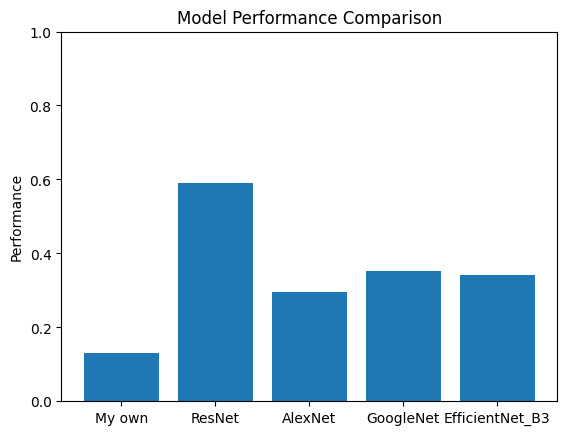

In [48]:
performance = [0.13, 0.59, 0.2947, 0.3526, 0.3423]
models = ['My own', 'ResNet', 'AlexNet', 'GoogleNet', 'EfficientNet_B3']

plt.bar(models, performance)
plt.ylabel('Performance')
plt.title('Model Performance Comparison')
plt.ylim(0, 1) 
plt.show()